### The purpose of nba-api is to scrape basketball-reference.com and extract matchup information and team statistics
Jake Giguere giguere@bu.edu

disclaimer: This is software is soley for educational purposes. Please do not use this for gambling or sport-betting.

In [2]:
import os
import time
from io import StringIO

import pandas as pd
import requests
import tensorflow as tf
from bs4 import BeautifulSoup

print("TensorFlow version:", tf.__version__)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

/Users/jakegiguere/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
2025-02-05 18:40:04.545594: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.2


In [20]:
# Dictionary mapping team names to their abbreviations
TEAM_MAP = {
    "Atlanta Hawks": "ATL",
    "Boston Celtics": "BOS",
    "Brooklyn Nets": "BRK",
    "Charlotte Hornets": "CHO",
    "Chicago Bulls": "CHI",
    "Cleveland Cavaliers": "CLE",
    "Dallas Mavericks": "DAL",
    "Denver Nuggets": "DEN",
    "Detroit Pistons": "DET",
    "Golden State Warriors": "GSW",
    "Houston Rockets": "HOU",
    "Indiana Pacers": "IND",
    "Los Angeles Clippers": "LAC",
    "Los Angeles Lakers": "LAL",
    "Memphis Grizzlies": "MEM",
    "Miami Heat": "MIA",
    "Milwaukee Bucks": "MIL",
    "Minnesota Timberwolves": "MIN",
    "New Orleans Pelicans": "NOP",
    "New York Knicks": "NYK",
    "Oklahoma City Thunder": "OKC",
    "Orlando Magic": "ORL",
    "Philadelphia 76ers": "PHI",
    "Phoenix Suns": "PHO",
    "Portland Trail Blazers": "POR",
    "Sacramento Kings": "SAC",
    "San Antonio Spurs": "SAS",
    "Toronto Raptors": "TOR",
    "Utah Jazz": "UTA",
    "Washington Wizards": "WAS"
}

# Reverse dictionary for abbreviation to full team name
ABBR_MAP = {abbr: team for team, abbr in TEAM_MAP.items()}

def get_team_name_or_abbr(input_str):
    """Convert a team name to its abbreviation or vice versa."""
    input_str = input_str.strip()
    
    # Check if the input is an abbreviation
    if input_str.upper() in ABBR_MAP:
        return ABBR_MAP[input_str.upper()]
    # Check if the input is a full team name
    elif input_str in TEAM_MAP:
        return TEAM_MAP[input_str]
    else:
        return "Team not found."

# Example Usage
print(get_team_name_or_abbr("Boston Celtics"))   # Output: "BOS"
print(get_team_name_or_abbr("LAL"))              # Output: "Los Angeles Lakers"
print(get_team_name_or_abbr("NYK"))              # Output: "New York Knicks"
print(get_team_name_or_abbr("Philadelphia 76ers"))  # Output: "PHI"
print(get_team_name_or_abbr("ATL"))              # Output: "Atlanta Hawks"


BOS
Los Angeles Lakers
New York Knicks
PHI
Atlanta Hawks


In [3]:
abv = list(TEAM_MAP.values())
abv

['ATL',
 'BOS',
 'BRK',
 'CHO',
 'CHI',
 'CLE',
 'DAL',
 'DEN',
 'DET',
 'GSW',
 'HOU',
 'IND',
 'LAC',
 'LAL',
 'MEM',
 'MIA',
 'MIL',
 'MIN',
 'NOP',
 'NYK',
 'OKC',
 'ORL',
 'PHI',
 'PHO',
 'POR',
 'SAC',
 'SAS',
 'TOR',
 'UTA',
 'WAS']

### Retreive Data from 2022-2024

In [73]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}
abreviations = list(TEAM_MAP.values()) #list of all abreviations
years = range(2023, 2026)
teams_data = pd.DataFrame()
for year in years:
    for abrv in abreviations:
        url = f'https://www.basketball-reference.com/teams/{abrv}/{year}/gamelog/'

        try:
            r = requests.get(url, headers=headers)
            r.raise_for_status()
        except Exception as e:
            print(f'Could not fetch {abrv}/{year}')
            r.raise_for_status()
        
        soup = BeautifulSoup(r.text, 'html.parser')
        table = soup.find('table', {'id': 'tgl_basic'})


        if table:
            table = StringIO(str(table))
            team = pd.read_html(table)[0]
            
            teams_data = pd.concat([teams_data, team], ignore_index=True)

    time.sleep(120)




In [22]:
teams_data.shape

(7038, 41)

### Save/Overwrite to gamelog csv file should have 2700x3 years about +8000 rows 

In [23]:
teams_data.to_csv('Data/gamelogs2022_2024.csv', mode='w+', index=False)

Clean up the game log. repeated headers, etc. save to Data/cleaned_gamelogs.csv


In [24]:
data = pd.read_csv('Data/gamelogs2022_2024.csv', header=1)
# data = data.drop(0, axis=0)

#Remove any multi labeled rows, and unnamed values

data = data.loc[:, ~data.columns.str.contains('Unnamed')]
data = data.rename(columns={'Tm': 'PTS', data.columns[7]: 'PTS.1'})
data = data[data['Rk'].apply(lambda x: str(x).isdigit())]

data.reset_index(drop=True, inplace=True)
# Display the first few rows of the cleaned DataFrame
data.to_csv('Data/cleaned_gamelogs.csv', index=False)


### Prepare the data for the Sequential Model

In [25]:
cleaned_df = pd.read_csv('Data/cleaned_gamelogs.csv')
print(cleaned_df.columns)

# Load the cleaned dataset
data = pd.read_csv('Data/cleaned_gamelogs.csv')
feature_columns = ['PTS.1', 
                # 'Home/Away', 'Home/Away.1',
                'FG%', 'FG%.1',
                'FGA', 'FGA.1',
                '3P%', '3P%.1',
                '3PA', '3PA.1',
                'ORB', 'ORB.1',
                'TRB', 'TRB.1',
                'AST', 'AST.1',
                'TOV', 'TOV.1',
                'STL', 'STL.1',

                
                
                'PF', 'PF.1']


data.to_csv('Data/cleaned_gamelogs.csv', index=False)

data = data.dropna(axis=0)
print(data.isna().any().sum())

features = data[feature_columns]
target = data['PTS']

# Split the data into training and testing sets (80% train, 20% test)
X_train, _, y_train, _ = train_test_split(features, target)

# Scale the features for better performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


print(X_train.shape)
# print(X_test.shape)

print(X_train[1:5])



Index(['Rk', 'G', 'Date', 'Opp', 'W/L', 'PTS', 'Opp.1', 'PTS.1', 'FGA', 'FG%',
       '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'FG.1', 'FGA.1', 'FG%.1', '3P.1', '3PA.1', '3P%.1',
       'FT.1', 'FTA.1', 'FT%.1', 'ORB.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1',
       'TOV.1', 'PF.1'],
      dtype='object')
0
(4827, 21)
[[-0.75357823 -0.29536028 -0.03922635 -0.78063735 -0.52251037 -0.19970627
   0.16505946 -0.91285806 -0.46666665 -0.91694533  0.35009402 -0.5475782
   0.65274367 -0.22053514 -0.21071998 -0.76288163 -0.24681196  0.13697196
  -0.54685601  1.63223648 -1.25295188]
 [ 1.35324271  0.38084855 -0.14838023  1.43330888 -0.38342591  0.33155973
   0.2373121   0.09645349  0.9801828   1.63558934 -0.16669614  1.25508845
  -1.14959803 -0.41532436 -0.21071998  0.25591201 -0.50203076 -0.20295794
  -0.20252077 -1.74074612 -0.77247532]
 [-1.13663658 -0.55122308 -0.40307262 -1.05738063 -0.93976374 -0.53778462
  -0.46113016  0.81739032 -0.61135

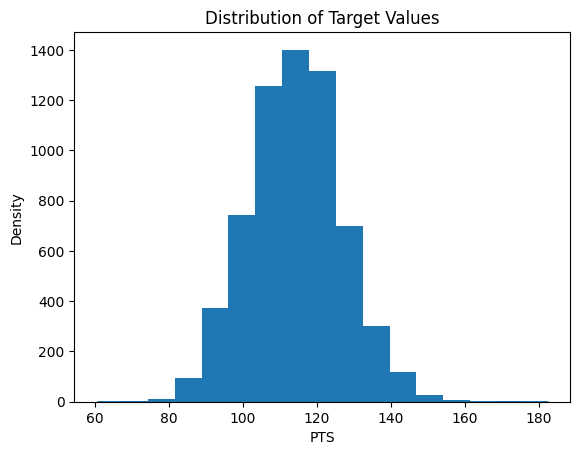

Target Value Stats:
count    6358.00000
mean      114.14470
std        12.46307
min        67.00000
25%       106.00000
50%       114.00000
75%       122.00000
max       176.00000
Name: PTS, dtype: float64


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(target, fill=True,)
plt.hist(target, bins=15)
plt.title("Distribution of Target Values")
plt.show()

print("Target Value Stats:")
print(target.describe())


### Check for NaNs or Infinite Values

In [9]:
import numpy as np

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

from keras import layers, callbacks


In [26]:

model = Sequential(
    [
    layers.Input(shape=(21,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    # layers.Dropout(0.1),
    layers.Dense(1)  # Output layer for regression
    ]
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Train the model
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=200, batch_size=8, validation_split=0.2, shuffle=True, callbacks=[lr_scheduler, early_stopping])



Epoch 1/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 12880.5850 - mae: 112.8190 - val_loss: 10269.1748 - val_mae: 100.7195 - learning_rate: 1.0000e-04
Epoch 2/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7583.3574 - mae: 84.4702 - val_loss: 981.0093 - val_mae: 26.7086 - learning_rate: 1.0000e-04
Epoch 3/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 775.3469 - mae: 22.7123 - val_loss: 601.9604 - val_mae: 19.5859 - learning_rate: 1.0000e-04
Epoch 4/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 551.9629 - mae: 18.8048 - val_loss: 525.3644 - val_mae: 18.2914 - learning_rate: 1.0000e-04
Epoch 5/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 481.0616 - mae: 17.4537 - val_loss: 474.3224 - val_mae: 17.2834 - learning_rate: 1.0000e-04
Epoch 6/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 446.5541 - mae: 16.8255 - val_loss: 417.1307 - val_mae: 16.3936 - learning_rate: 1.0000e-04
Epoch 7/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 389.6220 - mae

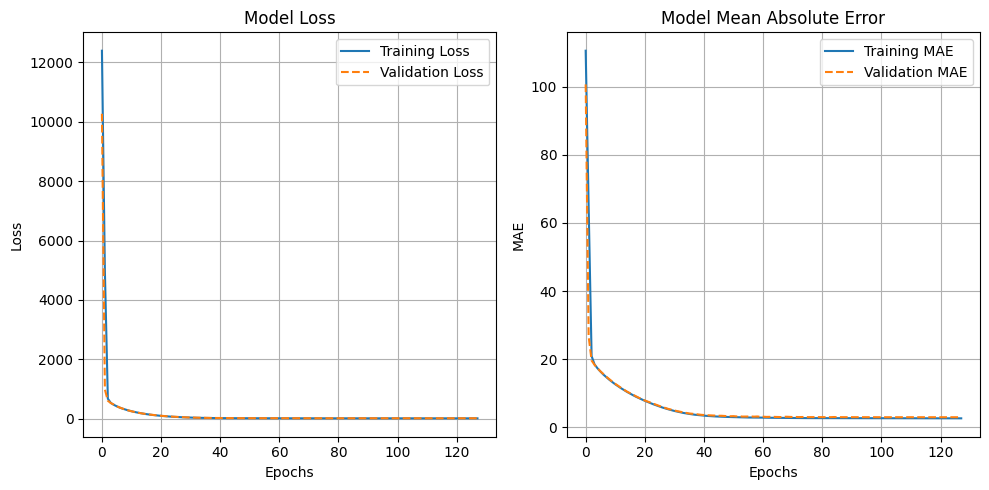

In [27]:
import matplotlib.pyplot as plt

# Assuming you have 'history.history' dictionary from model training
# Example: 'loss', 'val_loss', 'mae', and 'val_mae'

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


In [28]:
# Save the trained model right after training
model.save('nba_model.keras')
print("Model saved as 'nba_model.h5'")

Model saved as 'nba_model.h5'


### Evaluate model

In [76]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [77]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

NameError: name 'X_test' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Assuming `y_test` is the actual values and `predictions` are your model's predictions
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual', alpha=0.7)
plt.scatter(range(len(y_test)), y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Game Index')
plt.ylabel('Points')
plt.title('Actual vs Predicted Scores')
plt.legend()
plt.show()

In [30]:
# Step 1: Scrape today's games
from datetime import datetime

def get_today_games():
    month = datetime.now().strftime('%B')
    year = datetime.now().strftime('%Y')
    # Define the URL for the November 2024 NBA schedule
    url = f"https://www.basketball-reference.com/leagues/NBA_{year}_games-{month}.html"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the schedule table
    schedule_table = soup.find('table', {'id': 'schedule'})
    if not schedule_table:
        print("Schedule table not found.")
        return pd.DataFrame()
    
    # Extract rows from the table
    rows = schedule_table.find_all('tr')
    
    # Get today's date in the format used on the website
    today = datetime.now().strftime('%a, %b %-d, %Y')
    print(today)
    # tmrw = "Sat, Feb 8, 2025"
    # Initialize a list to hold today's games
    games_today = []
    
    for row in rows:
        # Extract the date cell
        date_cell = row.find('th', {'data-stat': 'date_game'})
        if date_cell and date_cell.text.strip() == today:
            # Extract team names
            away_team = row.find('td', {'data-stat': 'visitor_team_name'}).text.strip()
            home_team = row.find('td', {'data-stat': 'home_team_name'}).text.strip()
            games_today.append({'home_team': home_team, 'away_team': away_team})

        # if date_cell and date_cell.text.strip() == tmrw:
        #     # Extract team names
        #     away_team = row.find('td', {'data-stat': 'visitor_team_name'}).text.strip()
        #     home_team = row.find('td', {'data-stat': 'home_team_name'}).text.strip()
        #     games_today.append({'home_team': home_team, 'away_team': away_team})
    
    
    # Convert the list to a DataFrame
    return pd.DataFrame(games_today)

# Fetch today's games
today_games = get_today_games()
print("Today's Matchups:")


print(today_games)


NameError: name 'requests' is not defined

Get team current team per game data

In [45]:
def get_team_per_game_stats(team_abbr):
    """
    Scrapes the 'per_game' table for a given team using its abbreviation.
    """
    url = f"https://www.basketball-reference.com/teams/{team_abbr}/2025.html"
            
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Locate the per-game table
    per_game_table = soup.find('table', {'id': 'per_game_stats'})
    if not per_game_table:
        print(f"Per-game table not found for {team_abbr}.")
        return {}
    if per_game_table:
        table = StringIO(str(per_game_table))
        df = pd.read_html(table)[0]
        
        # Read the table using pandas
    
    
        # Extract the row corresponding to 'Team Totals'
        team_totals_row = df[df['Player'] == 'Team Totals']
        if team_totals_row.empty:
            print(f"No 'Team Totals' row found for {team_abbr}.")
            return {}

        # Convert the row to a dictionary
        team_stats = team_totals_row.iloc[0].to_dict()

        # Extract only the required columns
        feature_columns = ['PTS', 'FG%', 'FGA', '3P%', '3PA', 'ORB', 'TRB', 
                           'AST', 'TOV', 'STL', 'PF']
    
        # Map to desired format
        relevant_stats = {col: team_stats.get(col, 0) for col in feature_columns}

        return relevant_stats
    
        
    
home = get_team_name_or_abbr(today_games.iloc[0][0])
away = get_team_name_or_abbr(today_games.iloc[0][1])

home_teams = today_games['home_team']
away_teams = today_games['away_team']

home = get_team_per_game_stats(home)
away = get_team_per_game_stats(away)

print(today_games)



/var/folders/rr/ydryh0913_q6_r11vnv6jl9m0000gn/T/ipykernel_1448/311355562.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  home = get_team_name_or_abbr(today_games.iloc[0][0])
/var/folders/rr/ydryh0913_q6_r11vnv6jl9m0000gn/T/ipykernel_1448/311355562.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  away = get_team_name_or_abbr(today_games.iloc[0][1])


                 home_team               away_team
0         Dallas Mavericks         Houston Rockets
1       Los Angeles Lakers          Indiana Pacers
2            Orlando Magic       San Antonio Spurs
3       Washington Wizards           Atlanta Hawks
4            Chicago Bulls   Golden State Warriors
5        Memphis Grizzlies   Oklahoma City Thunder
6   Minnesota Timberwolves  Portland Trail Blazers
7          New York Knicks          Boston Celtics
8             Phoenix Suns          Denver Nuggets
9         Sacramento Kings    New Orleans Pelicans
10    Los Angeles Clippers               Utah Jazz


### Create a match up vector for both teams to follow the model features

In [46]:
def create_matchup_feature_vector(home_team, away_team, team_abbreviation_func):
    """
    For a given matchup, fetch stats for the home and away teams,
    and create a combined feature vector.
    """
    home_abbr = team_abbreviation_func(home_team)
    away_abbr = team_abbreviation_func(away_team)
    
    # Get stats for both teams
    home_stats = get_team_per_game_stats(home_abbr)
    away_stats = get_team_per_game_stats(away_abbr)
    
    
    # Rename away team columns with '.1' suffix
    away_stats = {f"{key}.1": value for key, value in away_stats.items()}
    
    # home_stats['Home/Away'] = 0
    # away_stats['Home/Away.1'] = 1
    
    # Combine home and away team stats
    combined_stats = {**home_stats, **away_stats}
    
    return combined_stats

### Get Data for todays games home teams

In [47]:

# Generate feature vectors for today's matchups
feature_vectors = []
for _, game in today_games.iterrows():
    features = create_matchup_feature_vector(
        game['home_team'],game['away_team'],get_team_name_or_abbr 
    )

    
    feature_vectors.append(features)

# Convert to a DataFrame for easy viewing
home_feature_df = pd.DataFrame(feature_vectors)



print("Feature Vectors for Today's Matchups:")
print(home_feature_df.columns)


# Filter the DataFrame to include only the columns your model expects
home_feature_df = home_feature_df[feature_columns]

# Check the shape to ensure it's correct
print("Adjusted Feature Vectors:")
print(home_feature_df)
print("Shape of feature_df:", home_feature_df.shape)

Feature Vectors for Today's Matchups:
Index(['PTS', 'FG%', 'FGA', '3P%', '3PA', 'ORB', 'TRB', 'AST', 'TOV', 'STL',
       'PF', 'PTS.1', 'FG%.1', 'FGA.1', '3P%.1', '3PA.1', 'ORB.1', 'TRB.1',
       'AST.1', 'TOV.1', 'STL.1', 'PF.1'],
      dtype='object')
Adjusted Feature Vectors:
    PTS.1    FG%  FG%.1   FGA  FGA.1    3P%  3P%.1   3PA  3PA.1   ORB  ...  \
0   113.4  0.478  0.449  88.3   93.2  0.369  0.343  35.3   35.5  11.1  ...   
1   115.7  0.482  0.490  85.2   88.4  0.359  0.369  33.8   34.2   9.1  ...   
2   112.8  0.438  0.459  85.8   89.5  0.303  0.349  36.3   39.7  11.3  ...   
3   116.1  0.437  0.461  90.4   91.7  0.333  0.346  38.6   37.4  10.9  ...   
4   111.5  0.467  0.444  91.8   91.6  0.373  0.362  43.0   42.5   9.7  ...   
5   117.7  0.487  0.476  93.5   92.4  0.374  0.354  37.7   38.5  13.3  ...   
6   109.0  0.463  0.451  86.2   88.6  0.385  0.345  39.3   35.8  10.9  ...   
7   117.3  0.495  0.459  88.9   90.7  0.375  0.367  34.5   48.3  11.0  ...   
8   120.8  0.475

In [49]:

# Generate feature vectors for today's matchups
feature_vectors = []
for _, game in today_games.iterrows():
    features = create_matchup_feature_vector(
        game['away_team'],game['home_team'],get_team_name_or_abbr 
    )

    
    feature_vectors.append(features)

# Convert to a DataFrame for easy viewing
away_feature_df = pd.DataFrame(feature_vectors)



# print("Feature Vectors for Today's Matchups:")
# print(away_feature_df.columns)


# Filter the DataFrame to include only the columns your model expects
away_feature_df = away_feature_df[feature_columns]

# Check the shape to ensure it's correct
print("Adjusted Feature Vectors:")
print(away_feature_df)
print("Shape of feature_df:", away_feature_df.shape)

Adjusted Feature Vectors:
    PTS.1    FG%  FG%.1   FGA  FGA.1    3P%  3P%.1   3PA  3PA.1   ORB  ...  \
0   115.5  0.449  0.478  93.2   88.3  0.343  0.369  35.5   35.3  14.6  ...   
1   112.6  0.490  0.482  88.4   85.2  0.369  0.359  34.2   33.8   9.0  ...   
2   103.8  0.459  0.438  89.5   85.8  0.349  0.303  39.7   36.3  11.2  ...   
3   107.8  0.461  0.437  91.7   90.4  0.346  0.333  37.4   38.6  11.9  ...   
4   116.7  0.444  0.467  91.6   91.8  0.362  0.373  42.5   43.0  12.6  ...   
5   123.8  0.476  0.487  92.4   93.5  0.354  0.374  38.5   37.7  10.7  ...   
6   111.7  0.451  0.463  88.6   86.2  0.345  0.385  35.8   39.3  12.5  ...   
7   117.9  0.459  0.495  90.7   88.9  0.367  0.375  48.3   34.5  10.9  ...   
8   113.4  0.507  0.475  89.8   85.4  0.378  0.378  31.2   37.4  11.2  ...   
9   116.1  0.446  0.473  90.3   91.0  0.349  0.346  35.3   35.6  12.1  ...   
10  110.1  0.456  0.470  87.8   86.3  0.354  0.359  38.9   33.9  12.3  ...   

     TRB  TRB.1   AST  AST.1   TOV  T

### Load out model 'nba_model.keras' and predict Home team scores

In [50]:
loaded_model = tf.keras.models.load_model('nba_model.keras')
# loaded_model = model
# Example: Make predictions using the loaded model

scaler = StandardScaler()
home_scaled_features = scaler.fit_transform(home_feature_df)
away_scaled_features = scaler.fit_transform(away_feature_df)

# Make predictions using the loaded model
home_predicted_scores = loaded_model.predict(home_scaled_features)
away_predicted_scores = loaded_model.predict(away_scaled_features)

# Add the predicted scores to the original DataFrame
today_games['home_predicted_scores'] = home_predicted_scores.flatten()
today_games['away_predicted_scores'] = away_predicted_scores.flatten()

# Display the results
print("\nPredicted Scores for Today's Matchups:")
print(today_games)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

Predicted Scores for Today's Matchups:
                 home_team               away_team  home_predicted_scores  \
0         Dallas Mavericks         Houston Rockets             118.128899   
1       Los Angeles Lakers          Indiana Pacers             116.957748   
2            Orlando Magic       San Antonio Spurs             105.004913   
3       Washington Wizards           Atlanta Hawks             116.069763   
4            Chicago Bulls   Golden State Warriors             113.776207   
5        Memphis Grizzlies   Oklahoma City Thunder             132.126816   
6   Minnesota Timberwolves  Portland Trail Blazers             108.288498   
7          New York Knicks          Boston Celtics             115.241592   
8             Phoenix Suns          Denver Nuggets             133.256912   
9         Sacramento Kings    New Orleans Pelicans             108.546364   
10    Los Angeles Clippers          

0.8740919432694625


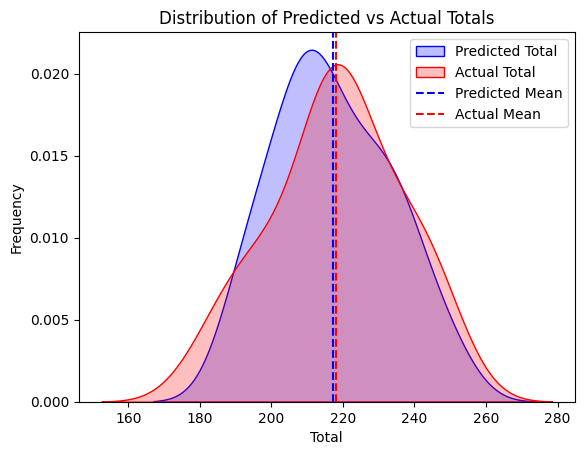

In [32]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
xlsx = pd.read_excel('data/nba.xlsx', sheet_name='Raw')
# print(xlsx.head())
xlsx.columns = xlsx.columns.str.strip()
team_name = 'CHA'
cle = xlsx[(xlsx['home'] == team_name) | (xlsx["away"] == team_name)]
# print(cle)
sns.kdeplot(cle['pred total'], color='blue', label='Predicted Total', fill=True)
sns.kdeplot(cle['Total Actual'], color='red', label='Actual Total', fill=True)

plt.axvline(cle['pred total'].mean(), color='blue', linestyle='--', label='Predicted Mean')
plt.axvline(cle['Total Actual'].mean(), color='red', linestyle='--', label='Actual Mean')
print(cle['Total Actual'].mean() - cle['pred total'].mean())
plt.title('Distribution of Predicted vs Actual Totals')
plt.xlabel('Total')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
cle['error'] = cle['pred total'] - cle['Actual']
sns.kdeplot(cle['error'], shade=True, color='purple')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.show()


### H2H Data


In [289]:
def get_h2h_stats(teamA, teamB):
    """
    Scrapes the 'per_game' table for a given team using its abbreviation.
    """
    url = f"https://stathead.com/basketball/versus-finder.cgi?request=1&match=versus_teamvteam&seasons_type=forall&year_min=2024&year_max=2025&team_id1={teamA}&team_id2={teamB}"
    
            
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Locate the per-game table
    h2h_table = soup.find('table', {'id': 'stats_h2h_per_game_rs'})
    if not h2h_table:
        #TODO get overall per game table
        print(f"Per-game table not found for {teamA} vs. {teamB}.")
        return {}
    if h2h_table:
        table = StringIO(str(h2h_table))
        df = pd.read_html(table)[0]
        

        feature_columns = ['PTS', 'FG%', 'FGA', '3P%', '3PA', 'ORB', 'TRB', 'AST', 'TOV', 'STL', 'PF']
        relevant_stats = {col: df.get(col, 0) for col in feature_columns}
        
        return relevant_stats


In [290]:
def create_h2h_feature_vector(home_team, away_team, team_abbreviation_func):
    """
    For a given matchup, fetch stats for the home and away teams,
    and create a combined feature vector.
    """
    home_abbr = team_abbreviation_func(home_team)
    away_abbr = team_abbreviation_func(away_team)
    
    # Get stats for both teams
    h2h_stats = pd.DataFrame(get_h2h_stats(home_abbr, away_abbr))
    home_stats = h2h_stats.iloc[0]
    away_stats = h2h_stats.iloc[1]                
    
    # Rename away team columns with '.1' suffix
    away_stats = {f"{key}.1": value for key, value in away_stats.items()}
    
    # home_stats['Home/Away'] = 0
    # away_stats['Home/Away.1'] = 1
    
    # Combine home and away team stats
    combined_stats = {**home_stats, **away_stats}
    
    return combined_stats

In [291]:

# Generate feature vectors for today's matchups
feature_vectors = []
for _, game in today_games.iterrows():
    features = create_h2h_feature_vector(
        game['home_team'],game['away_team'],get_team_name_or_abbr 
    )

    
    feature_vectors.append(features)

# Convert to a DataFrame for easy viewing
feature_df = pd.DataFrame(feature_vectors)



print("Feature Vectors for Today's Matchups:")
print(feature_df.columns)


# Filter the DataFrame to include only the columns your model expects


# Check the shape to ensure it's correct
print("Adjusted Feature Vectors:")
print(home_feature_df)
print("Shape of feature_df:", home_feature_df.shape)

Feature Vectors for Today's Matchups:
Index(['PTS', 'FG%', 'FGA', '3P%', '3PA', 'ORB', 'TRB', 'AST', 'TOV', 'STL',
       'PF', 'PTS.1', 'FG%.1', 'FGA.1', '3P%.1', '3PA.1', 'ORB.1', 'TRB.1',
       'AST.1', 'TOV.1', 'STL.1', 'PF.1'],
      dtype='object')
Adjusted Feature Vectors:
   PTS.1    FG%  FG%.1   FGA  FGA.1    3P%  3P%.1   3PA  3PA.1   ORB  ...  \
0  107.1  0.455  0.473  83.6   80.5  0.331  0.364  33.2   31.6   9.8  ...   
1  117.4  0.488  0.467  95.3   95.7  0.409  0.342  42.3   38.9  14.7  ...   
2  121.6  0.480  0.484  94.6   91.7  0.354  0.370  32.7   33.6  13.1  ...   
3  111.8  0.421  0.464  89.0   84.0  0.297  0.357  37.0   39.3  13.0  ...   
4  114.3  0.424  0.464  87.6   91.7  0.328  0.369  41.4   38.7  10.0  ...   
5  110.2  0.483  0.463  89.4   91.4  0.384  0.351  33.3   37.0   9.9  ...   

    TRB  TRB.1   AST  AST.1   TOV  TOV.1  STL  STL.1    PF  PF.1  
0  40.4   41.6  21.9   24.1  16.1   16.1  8.4    8.7  22.0  21.2  
1  51.6   42.3  27.0   28.3  14.7   12.2  7.

In [292]:
loaded_model = tf.keras.models.load_model('nba_model.keras')

# loaded_model = model
# Example: Make predictions using the loaded model
print(feature_df.columns)

home_vect_df = feature_df.drop(['PTS'], axis=1)
away_vect_df = feature_df.drop(['PTS.1'], axis=1)

# home_vect = vect_df.drop(['PTS'], axis=1)
# away_vect = vect_df.drop(['PTS.1'], axis=1)

scaler = StandardScaler()
home_scaled_features = scaler.fit_transform(home_vect_df)
away_scaled_features = scaler.fit_transform(away_vect_df)

# Make predictions using the loaded model
home_predicted_scores = loaded_model.predict(home_scaled_features)
away_predicted_scores = loaded_model.predict(away_scaled_features)

# Add the predicted scores to the original DataFrame


today_games['home_predicted_scores'] = home_predicted_scores.flatten()
today_games['away_predicted_scores'] = away_predicted_scores.flatten()

# Display the results
print("\nPredicted Scores for Today's Matchups:")
print(today_games)

Index(['PTS', 'FG%', 'FGA', '3P%', '3PA', 'ORB', 'TRB', 'AST', 'TOV', 'STL',
       'PF', 'PTS.1', 'FG%.1', 'FGA.1', '3P%.1', '3PA.1', 'ORB.1', 'TRB.1',
       'AST.1', 'TOV.1', 'STL.1', 'PF.1'],
      dtype='object')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Predicted Scores for Today's Matchups:
                home_team          away_team  home_predicted_scores  \
0           Orlando Magic      Brooklyn Nets             114.819077   
1          Boston Celtics     Indiana Pacers             119.169876   
2         Toronto Raptors      Atlanta Hawks             142.273758   
3         Houston Rockets         Miami Heat             116.004677   
4   Oklahoma City Thunder  Memphis Grizzlies             105.903557   
5  Minnesota Timberwolves  San Antonio Spurs              98.664680   

   away_predicted_scores  teamA_predicted_scores  teamB_predicted_scores  
0             120.055534              112.055656              115.632149  
1             127.